# Project 3 Computer Vision

* Kajetan Sulwiński 151954
* Mikołaj Marmurowicz 151956

Github Link: https://github.com/ekohachi22/CV-project3

## Necessary imports and helper functions.

In [21]:
import cv2
import os
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import keras
from tensorflow.keras import layers, models, callbacks
from tensorflow.keras.utils import plot_model
from sklearn.model_selection import train_test_split
from tensorflow.keras.models import model_from_json
from sklearn.metrics import mean_squared_error
from tensorflow.keras.metrics import MeanAbsoluteError, MeanAbsolutePercentageError, RootMeanSquaredError
import pickle
import tensorflow as tf

from imgaug.augmentables.kps import KeypointsOnImage
from imgaug.augmentables.kps import Keypoint
import imgaug.augmenters as iaa

In [2]:
def imshow(img):
    plt.imshow(img, cmap='Greys')
    plt.show()

In [3]:
def drawKeypoints(pred, img):
    out = cv2.cvtColor((img.copy() *255).astype(np.uint8), cv2.COLOR_GRAY2BGR)
    for i in range(0, len(pred), 2):
        x, y = int(pred[i]), int(pred[i + 1])
        cv2.circle(out, (x, y), 3, (255, 0, 0), -1)
    return out

In [23]:
def saveModel(model, history, model_json_path, model_weights_path, model_history_path):
    model_json = model.to_json()
    with open(model_json_path, "w") as json_file:
        json_file.write(model_json)
    model.save_weights(model_weights_path)
    with open(model_history_path, 'wb') as pickle_file:
        pickle.dump(history.history, pickle_file)

def loadModel(model_path, model_weights_path, model_history_path):
    with open(model_path, "r") as json_file:
        loaded_model_json = json_file.read()
        loaded_model = model_from_json(loaded_model_json)
    loaded_model.load_weights(model_weights_path)
    with open(model_history_path, "rb") as pickle_file:
        history = pickle.load(pickle_file)
    return loaded_model, history

## Data loading.

Our dataset consisted of 4 files:

* IDLookupTable.csv - not needed for our purpose
* SampleSubmission.csv - not needed for our purpose
* test.zip containing test.csv - file represents unfilled data that was supposed to be uploaded to the kaggle platform to test the results, thus we will not be using that.
* training.zip containig training.csv - the file that we will use for all train, validation and test sets.

This dataset consisted of 7049 images of size (96x96) as well as their keypoints. Sadly most of the keypoints were not full, thus we needed to discrad most of the data. In the end we had 2140 full data points to work with.

In [5]:
data = pd.read_csv('training/training.csv')

In [6]:
X_data = []
y_data = []
for index, row in data.iterrows():
    image = np.reshape(np.array(row['Image'].split(' '), dtype=int), (96, 96, 1))
    X_data.append(image)
    keypoints_values = row.iloc[:-1].values.astype(np.float32)
    y_data.append(keypoints_values)

X_data = np.array(X_data)
y_data = np.array(y_data)

In [7]:
nan_mask = np.isnan(y_data)
rows_without_nan = ~np.any(nan_mask, axis=1)
X_data = X_data[rows_without_nan]
y_data = y_data[rows_without_nan]
print(X_data.shape)
print(y_data.shape)

(2140, 96, 96, 1)
(2140, 30)


Resizing each image to fit the requirements of 224x224 image size.

In [8]:
min = 0
max = 255
X_data = (X_data - min) / (max - min)
resized_images = []
for image in X_data:
    resized_image = cv2.resize(image, (224, 224))
    resized_images.append(resized_image)

X_data = np.array(resized_images)
y_data = y_data * (224/96)

In [9]:
print(X_data.shape)
print(y_data.shape)

(2140, 224, 224)
(2140, 30)


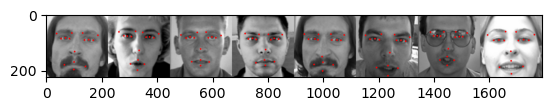

In [10]:
imshow(np.concatenate([drawKeypoints(true, img) for true, img in zip(y_data[:8], X_data[:8])],1))

In [11]:
y_df = pd.DataFrame(y_data, columns = data.columns[:-1])
y_df.head(5)

,left_eye_center_x,left_eye_center_y,right_eye_center_x,right_eye_center_y,left_eye_inner_corner_x,left_eye_inner_corner_y,left_eye_outer_corner_x,left_eye_outer_corner_y,right_eye_inner_corner_x,right_eye_inner_corner_y,...,nose_tip_x,nose_tip_y,mouth_left_corner_x,mouth_left_corner_y,mouth_right_corner_x,mouth_right_corner_y,mouth_center_top_lip_x,mouth_center_top_lip_y,mouth_center_bottom_lip_x,mouth_center_bottom_lip_y
0,154.078308,91.005302,70.529678,84.983910,139.024841,92.510651,170.637466,93.263321,84.831993,87.241928,...,103.647995,133.155869,142.789047,186.597061,66.767159,180.574310,101.062737,170.182724,100.638313,197.133453
1,150.110184,81.596848,69.881645,78.046997,137.331055,82.306808,165.019684,84.436714,84.081024,80.176903,...,112.481361,129.875504,131.650040,178.154648,81.952225,177.444534,108.930725,163.955292,106.091797,199.453720
2,151.799789,81.455826,72.108841,81.455826,138.627991,84.748924,165.630310,84.748924,87.915573,84.748924,...,110.966942,124.924210,141.920212,170.366730,78.694733,169.707993,110.308212,163.780838,110.308212,183.538528
3,152.193390,86.944130,74.720551,86.944130,140.007782,91.296745,168.734329,89.555588,87.776833,90.426270,...,121.065178,126.388588,153.064056,169.642014,86.906151,173.122787,117.374046,163.547272,120.309425,182.626205
4,155.692368,92.449608,75.237885,88.764732,136.653748,92.449608,169.203827,93.063759,86.292213,91.221321,...,101.032242,151.408875,141.566620,180.887558,72.780762,179.660355,104.913078,171.983902,103.196663,202.699371


Splitting real data into 3 sets:
* training (70%)
* validation (15%)
* test (15%)

In [12]:
X_train, X_temp, y_train, y_temp = train_test_split(X_data, y_data, test_size = 0.3)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size = 0.5)

## <a name="data-gen"></a> Data Generation

We have decided to generate data based on the examples in the dataset by rotation, scaling and translation.

In [13]:
def model_output_to_keypoints_coordinates(output: np.array) -> dict:
    ret = {}
    for i in range(0, len(data.columns[:-1]), 2):
        keypoint_name = data.columns[i][:-2]
        keypoint_coordinates = output[(i):(i+2)]
        ret[keypoint_name] = keypoint_coordinates
    return ret

Data generation class to customize the image generation along with the keypoints.

In [14]:
class DataGenerator(keras.utils.Sequence):
    def __init__(
        self,
        X_data: np.array,
        y_data: np.array,
        batch_size: int,
        shuffle: bool = True,
        aug: iaa.Augmenter = None
    ):
        self.X_data = X_data
        self.y_data = y_data
        self.batch_size = batch_size
        self.shuffle = shuffle
        self.aug = aug
        self.indexes = np.arange(len(self.X_data))
        self.on_epoch_end()

    def _data_generation(self, index_array):
        keypoints_ret = np.zeros_like(self.y_data[index_array])
        images_ret = np.zeros_like(self.X_data[index_array])
        if self.aug is not None:
            for i, index in enumerate(index_array):
                kps = []
                kps_cords = model_output_to_keypoints_coordinates(self.y_data[index])
                for _, keyp in kps_cords.items():
                    kps.append(Keypoint(x=keyp[0], y=keyp[1]))
                kps_obj = KeypointsOnImage(kps, shape=self.X_data[index].shape)
                augmented_img, augmented_kps = self.aug(image=self.X_data[index], keypoints=kps_obj)
                augmented_kps = np.array([[kp.x, kp.y] for kp in augmented_kps.keypoints])
                augmented_kps = augmented_kps.flatten()
                keypoints_ret[i] = augmented_kps
                images_ret[i] = augmented_img
        return images_ret, keypoints_ret
    
    def __len__(self):
        return len(self.indexes) // self.batch_size

    def on_epoch_end(self):
        if self.shuffle:
            np.random.shuffle(self.indexes)

    def __getitem__(self, index):
        batch_indexes = self.indexes[index * self.batch_size:(index + 1) * self.batch_size]
        return self._data_generation(batch_indexes)

Examplary generated data.

(2112, 224, 224)
(2112, 30)


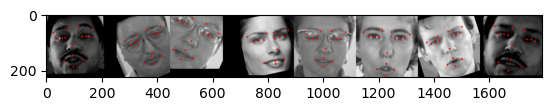

In [15]:
INPUT_SIZE = (224, 224, 1)

aug = iaa.Sequential(
    [
        iaa.Resize(INPUT_SIZE[:2], interpolation="linear"),
        iaa.Fliplr(0.1),
        iaa.Sometimes(0.8, iaa.Affine(rotate=(-40, 40), scale=(0.75, 1.25))),
        iaa.Sometimes(0.8, iaa.Affine(translate_percent={"x": (-0.15, 0.15), "y": (-0.15, 0.15)}))
    ]
)

gen = DataGenerator(X_data, y_data, 32, aug=aug)

aug_X = []
aug_y = []
for epoch in range(1):
    gen.on_epoch_end()
    for batch_index in range(len(gen)):
        X_batch, y_batch = gen[batch_index]
        aug_X.append(X_batch)
        aug_y.append(y_batch)
aug_X = np.array(aug_X)
aug_y = np.array(aug_y)

aug_X = aug_X[:, :, :, :].reshape((-1,) + (224,224))
aug_y = aug_y[:, :, :].reshape((-1, 30))
print(aug_X.shape)
print(aug_y.shape)
imshow(np.concatenate([drawKeypoints(keypoints,image) for keypoints, image in zip(aug_y[:8], aug_X[:8])], 1))

Creating instances of generators for each train, validation and test sets seperately.

In [16]:
batch_size = 32
train_data_generator = DataGenerator(X_train, y_train, batch_size, True, aug)
val_data_generator = DataGenerator(X_val, y_val, batch_size, True, aug)
test_data_generator = DataGenerator(X_test, y_test, batch_size, True, aug)

## <a name="problem"></a> Problem

We have decided to dwelve into the pose estimation, which can be done by finding the face keypoints. Additionally, we wanted to do the pose estimation to be able to create some sort of an image filter, which allows users to take a picture and add sunglasses to their face based on the estimated face pose with keypoints.

## <a name="model-1"></a> Model 1

The first model that we created consists of 3 convolution blocks (convolution with maxPooling), flattening layer, 2 fully connected layers and an output layer.

In [ ]:
def createModel(input_shape, num_keypoints):
    model = models.Sequential()

    model.add(layers.Conv2D(32, (3, 3), activation='relu', input_shape=input_shape))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(64, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Conv2D(128, (3, 3), activation='relu'))
    model.add(layers.MaxPooling2D((2, 2)))

    model.add(layers.Flatten())

    model.add(layers.Dense(256, activation='relu'))
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(128, activation='relu'))

    model.add(layers.Dense(num_keypoints, activation='linear'))

    return model


input_shape = (224, 224,1)
num_keypoints = y_data.shape[1]

model = createModel(input_shape, num_keypoints)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError(), RootMeanSquaredError()])

model.summary()

In [ ]:
plot_model(model)

As we can see the given model is relatively large (second largest out of all created models), as it contains 22.2 mln trainable parameters. This model when stored takes up to 88 MB of pure weights and 5KB of model architecture.

Creating an early stopping condition with patience = 8 along with learning rate reduction on plateau callback with patience = 8.

In [ ]:
early_stopping = callbacks.EarlyStopping(monitor='val_loss', patience=8, restore_best_weights=True)
LR_callback = keras.callbacks.ReduceLROnPlateau(monitor='val_loss', patience=4, verbose=10, factor=.5, min_lr=.0000001)

Now we train the model on the generated data with validation set that is also generated/ loading the previously trained model. 

That means that training set in total conists of approximately 

$(2140 * 0.7 // 32) * 32 * 20 = 29440$ (1472 per epoch) examples

The validation set consists of 

$(2140 * 0.15 // 32) * 32 * 20 = 6400$ (320 per epoch) examples.

In [ ]:
# num_batches = 20
# history = model.fit(train_data_generator, epochs=num_batches, validation_data=val_data_generator, callbacks=[early_stopping, LR_callback])

In [ ]:
model, history = loadModel('model1.json', 'model_weights1.h5', 'model_history1.pickle')

<a name="test-gen"></a> Test Generation.

Now we create 10 000 examples (10240 to be exact) for the evaluation of the model (test set) via previously created test data generator.

In [17]:
aug_X_test = []
aug_y_test = []
for epoch in range(10000 // len(X_test) + 1):
    test_data_generator.on_epoch_end()
    for batch_index in range(len(test_data_generator)):
        X_batch_test, y_batch_test = test_data_generator[batch_index]
        aug_X_test.append(X_batch_test)
        aug_y_test.append(y_batch_test)
aug_X_test = np.array(aug_X_test)
aug_y_test = np.array(aug_y_test)

aug_X_test = aug_X_test[:, :, :, :].reshape((-1,) + (224,224))
aug_y_test = aug_y_test[:, :, :].reshape((-1, 30))
print(aug_X_test.shape)
print(aug_y_test.shape)

(10240, 224, 224)
(10240, 30)


Make predictions.

In [ ]:
y_pred = model.predict(aug_X_test)

Results of evaluation.

In [ ]:
y_pred_flat = y_pred.flatten()
aug_y_test_flat = aug_y_test.flatten()

mse1 = mean_squared_error(y_pred_flat, aug_y_test_flat)
print(f"Mean squared error on test set = {mse1}.")
imshow(np.concatenate([drawKeypoints(keypoints,image) for keypoints, image in zip(y_pred[:8], aug_X_test[:8])], 1))

Saving the model along with its weights and history.

In [ ]:
# saveModel(model, history, 'model1.json', 'model_weights1.h5', 'model_history1.pickle')

## <a name="model-2"></a> Model 2

The second model that we have created consists of a convolutional block, after which a ready architecture of MobileNetV2 (imagenet) model is used, at the end we have a dropout and pooling layers with the output layer.

In [ ]:
def createModel2(input_shape, num_keypoints):
    model2 = keras.models.Sequential()

    pretrained_model = keras.applications.MobileNetV2(
        input_shape=input_shape[:2] + (3,),
        alpha=1.0,
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        pooling=None,
        classifier_activation='linear'
    )
    pretrained_model.trainable = True

    model2.add(layers.Convolution2D(3, (1, 1), padding='same', input_shape=input_shape))
    model2.add(layers.LeakyReLU(alpha = 0.1))
    model2.add(layers.Lambda(keras.applications.mobilenet.preprocess_input))

    model2.add(pretrained_model)

    model2.add(layers.Dropout(0.3))
    model2.add(layers.GlobalAveragePooling2D())
    model2.add(layers.Dense(num_keypoints, activation='linear'))
    
    return model2


input_shape = (224, 224,1)
num_keypoints = y_data.shape[1]

model = createModel2(input_shape, num_keypoints)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError(), RootMeanSquaredError()])

model.summary()

In [ ]:
plot_model(model)

This model makes use of a ready architecture - MobileNetV2 (imagenet) with addition to our layers. We have decided to firstly try training the ready architecture ourselves, thus 2.3mln parameters are trainable in this case. The model can be stored within 81KB, while its weights within 10MB.

Training the model with previously created callbacks and generators / loading the previously trained model.

In [ ]:
# num_batches = 20
# history = model.fit(train_data_generator, epochs=num_batches, validation_data=val_data_generator, callbacks=[early_stopping, LR_callback])

In [ ]:
model, history = loadModel('model2.json', 'model_weights2.h5', 'model_history2.pickle')

Evaluating the model performance with previosuly generated data.

In [ ]:
y_pred = model.predict(aug_X_test)

In [ ]:
y_pred_flat = y_pred.flatten()

mse2 = mean_squared_error(y_pred_flat, aug_y_test_flat)
print(f"Mean squared error on test set = {mse2}.")
imshow(np.concatenate([drawKeypoints(keypoints,image) for keypoints, image in zip(y_pred[8:16], aug_X_test[8:16])], 1))

Saving the model along with its weights and history.

In [ ]:
# saveModel(model, history, 'model2.json', 'model_weights2.h5', 'model_history2.pickle')

## <a name="model-3"></a> Model 3

Now we have decided to slightly change the first model, by applying small changes such as batch normalization and dropout in the convolutional blocks, while also changing the number of convolutional blocks.

In [ ]:
def createModel3(input_shape, num_keypoints):
    model3 = keras.models.Sequential()

    model3.add(layers.Convolution2D(16, (3, 3), input_shape = input_shape, activation = 'relu'))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPool2D())
    model3.add(layers.Dropout(0.3))

    model3.add(layers.Convolution2D(32, (3, 3)))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPool2D())
    model3.add(layers.Dropout(0.3))


    model3.add(layers.Convolution2D(64, (3, 3)))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPool2D())
    model3.add(layers.Dropout(0.3))

    model3.add(layers.Convolution2D(128, (3, 3)))
    model3.add(layers.BatchNormalization())
    model3.add(layers.MaxPool2D())
    model3.add(layers.Dropout(0.3))

    model3.add(layers.Flatten())

    model3.add(layers.Dense(256, activation='relu'))
    model3.add(layers.Dropout(0.5))
    model3.add(layers.Dense(128, activation='relu'))
    
    model3.add(layers.Dense(num_keypoints, activation='linear'))
    
    return model3

input_shape = (224, 224,1)
num_keypoints = y_data.shape[1]

model = createModel3(input_shape, num_keypoints)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError(), RootMeanSquaredError()])

model.summary()

In [ ]:
plot_model(model)

After the changes made to the model from model 1, we have significantly lowered the complexity of the model, as well as the amount of memory that it requires to be stored. It consists of 4.9 mln parameters, that are stored within around 19MB, and the model itself that requires 8KB.

Training the model with previous callbacks and data generators / loading the model and its training history.

In [ ]:
# num_batches = 20
# history = model.fit(train_data_generator, epochs=num_batches, validation_data=val_data_generator, callbacks=[early_stopping, LR_callback])

In [ ]:
model, history = loadModel('model3.json', 'model_weights3.h5', 'model_history3.pickle')

Evaluating the model on previously created test set.

In [ ]:
y_pred = model.predict(aug_X_test)

In [ ]:
y_pred_flat = y_pred.flatten()

mse3 = mean_squared_error(y_pred_flat, aug_y_test_flat)
print(f"Mean squared error on test set = {mse3}.")
imshow(np.concatenate([drawKeypoints(keypoints,image) for keypoints, image in zip(y_pred[8:16], aug_X_test[8:16])], 1))

Saving the model with weights and history.

In [ ]:
# saveModel(model, history, 'model3.json', 'model_weights3.h5', 'model_history3.pickle')

## <a name="model-4"></a> Model 4

Now we have decided to test the model 2, but using transfer learning, while also applying changes that we have thought of based on the previous experiments. We added batch normalization after flattening and after that a fully connected layer with dropout.

In [ ]:
def createModel4(input_shape, num_keypoints):
    model4 = keras.models.Sequential()

    pretrained_model = keras.applications.MobileNetV2(
        input_shape=input_shape[:2] + (3,),
        alpha=1.0,
        include_top=False,
        weights="imagenet",
        input_tensor=None,
        pooling=None,
        classifier_activation='linear'
    )
    pretrained_model.trainable = False

    model4.add(layers.Convolution2D(3, (1, 1), padding='same', input_shape=input_shape))
    model4.add(layers.LeakyReLU(alpha=0.1))
    model4.add(layers.Lambda(keras.applications.mobilenet.preprocess_input))

    model4.add(pretrained_model)
   
    model4.add(layers.Flatten())
    model4.add(layers.BatchNormalization())

    model4.add(layers.Dense(512, activation='relu'))
    model4.add(layers.Dropout(0.5))

    model4.add(layers.Dense(num_keypoints, activation='linear'))

    return model4

input_shape = (224, 224,1)
num_keypoints = y_data.shape[1]

model = createModel4(input_shape, num_keypoints)

model.compile(optimizer='adam', loss='mean_squared_error', metrics=[MeanAbsoluteError(), MeanAbsolutePercentageError(), RootMeanSquaredError()])

model.summary()

In [ ]:
plot_model(model)

This model is a collection of everything that we have learned from the previous models, it applies all of the previous methods together, thus the number of parameters is the largest, although 2.3mln parameters are not trainable as we have applied transfer learning, it still has other 32 mln parameters. In total storing the weights takes about 135MB, and the model itself 82KB.

Model training/ loading.

In [ ]:
# num_batches = 20
# history = model.fit(train_data_generator, epochs=num_batches, validation_data=val_data_generator, callbacks=[early_stopping, LR_callback])

In [18]:
model, history = loadModel('model4.json', 'model_weights4.h5', 'model_history4.pickle')

Predictions and evaluation.

In [19]:
y_pred = model.predict(aug_X_test)

320/320 [==============================] - 173s 503ms/step


Mean squared error on test set = 494.08843994140625.


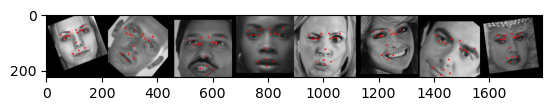

In [20]:
y_pred_flat = y_pred.flatten()
aug_y_test_flat = aug_y_test.flatten()

mse4 = mean_squared_error(y_pred_flat, aug_y_test_flat)
print(f"Mean squared error on test set = {mse4}.")
imshow(np.concatenate([drawKeypoints(keypoints,image) for keypoints, image in zip(y_pred[8:16], aug_X_test[8:16])], 1))

Saving the model.

In [ ]:
# saveModel(model, history, 'model4.json', 'model_weights4.h5', 'model_history4.pickle')

In [24]:
# tf.keras.models.save_model(model, 'model4_keras.keras', overwrite=True, save_format="keras")

## Used metrics, loss and evaluation.

Each model was trained using the same loss function as well as the same metrics were considered. All of the models were evaluated on a test set that consisted of 10240 data points that were generated from the previously derived test set from the original data.

As a loss function we have decided to use Mean Squared Error, as it measures the distance between the actual and calculated coordinates of points.

As metrics we have decided to use Mean Absolute Error, Mean Absolute Percentage Error and Root Mean Squared Error, becuase of the fact that MAE can provide insight into the actual magnitude of errors, whila MAPE provides insight to relative models accuracy. The RMSE is similar to the loss function, but we have decided to also include it here.

## Used hyperparameters.

**Learning rate** - chosen as initial 0.001, additionally provided callback for lowering the learning rate times $1/2$ with patience = 4. We have chosen such initial value, as higher values of learning rate had troubles with convergence, while lower values converged very slowly. Thus we have tried to find a balance and chosen 0.001 as initial value, allowing the value to be lowered if the model finds it difficult to converge.

**Image size** - chosen as 224x224, as the MobileNetV2 is made to work the best for images with such size.

**Dropout fraction** - depending on the model and layer either 0.5 or 0.3. This was chosen by trial and error to find a solution to model overfitting the train set. 0.5 is usually located near layers with larger input, while 0.3 is used far more often between a lot of layers.

## Training and inference time.

The models were trained on our lapotps CPUs, thus the training and inference times were large to say the least. 

The first model along with the second model took less time than model number 2 and 4, that is approximately 17 minutes for model 1, while approximately 9 minutes for model number 3. That has come at a cost of slightly worse results in the model number 3 though.

The fourth model that used a pretrained model (transfer learning) was able to finish learning faster than model nr 2, even though some other layers were added additionally. Model number 2 trained weights not only of our layers but also of the mobilenet architecture, thus it took considerable more time. Model number two took aproximately 38 minutes to train, while model number 4 took around 26 minutes.

The time of predictions scales similarily for all the models.

## Model comparison.

Now let us compare all the models. First let us take a look at mean squared error of each model on the test set of 10240 images.

In [ ]:
for count, mse in enumerate([mse1, mse2, mse3, mse4]):
    print(f"The value of mse for model {count + 1} = {mse}.")

Now let us see the comparison of loss am=nd metrics of each model on train and validation sets.

In [36]:
def plot_metrics(history, number):
    plt.figure(figsize=(20, 5))
    plt.subplot(1, 4, 1)
    plt.plot(history['loss'], label='Training Loss')
    plt.plot(history['val_loss'], label='Validation Loss')
    plt.title(f'Model {number} Loss')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    
    plt.subplot(1, 4, 2)
    plt.plot(history['mean_absolute_error'], label='Training MAE')
    plt.plot(history['val_mean_absolute_error'], label='Validation MAE')
    plt.title(f'Model {number} MAE')
    plt.xlabel('Epoch')
    plt.ylabel('MAE')
    plt.legend()

    plt.subplot(1, 4, 3)
    plt.plot(history['root_mean_squared_error'], label='Training MAE')
    plt.plot(history['val_root_mean_squared_error'], label='Validation MAE')
    plt.title(f'Model {number} RMSE')
    plt.xlabel('Epoch')
    plt.ylabel('RMSE')
    plt.legend()

    plt.subplot(1, 4, 4)
    plt.plot(history['mean_absolute_percentage_error'], label='Training MAE')
    plt.plot(history['val_mean_absolute_percentage_error'], label='Validation MAE')
    plt.title(f'Model {number} MAPE')
    plt.xlabel('Epoch')
    plt.ylabel('MAPE')
    plt.legend()

    plt.tight_layout()
    plt.show()


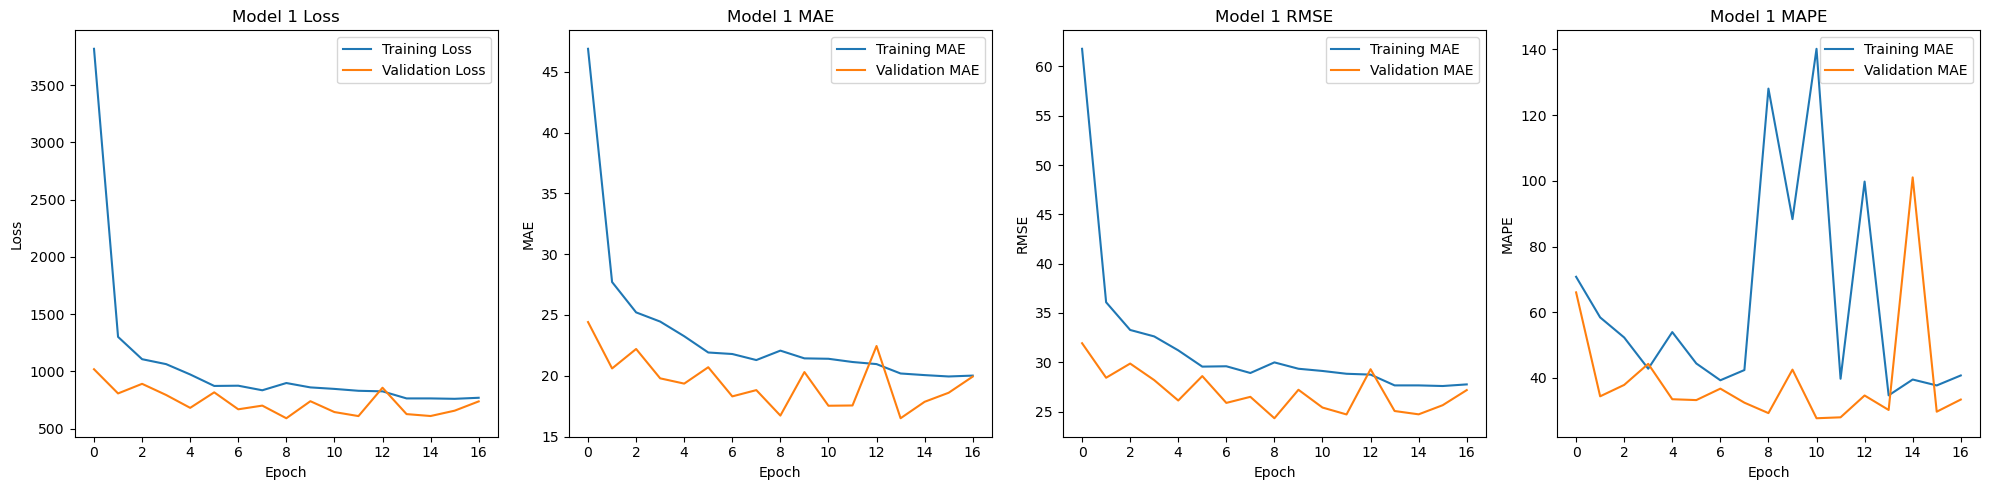

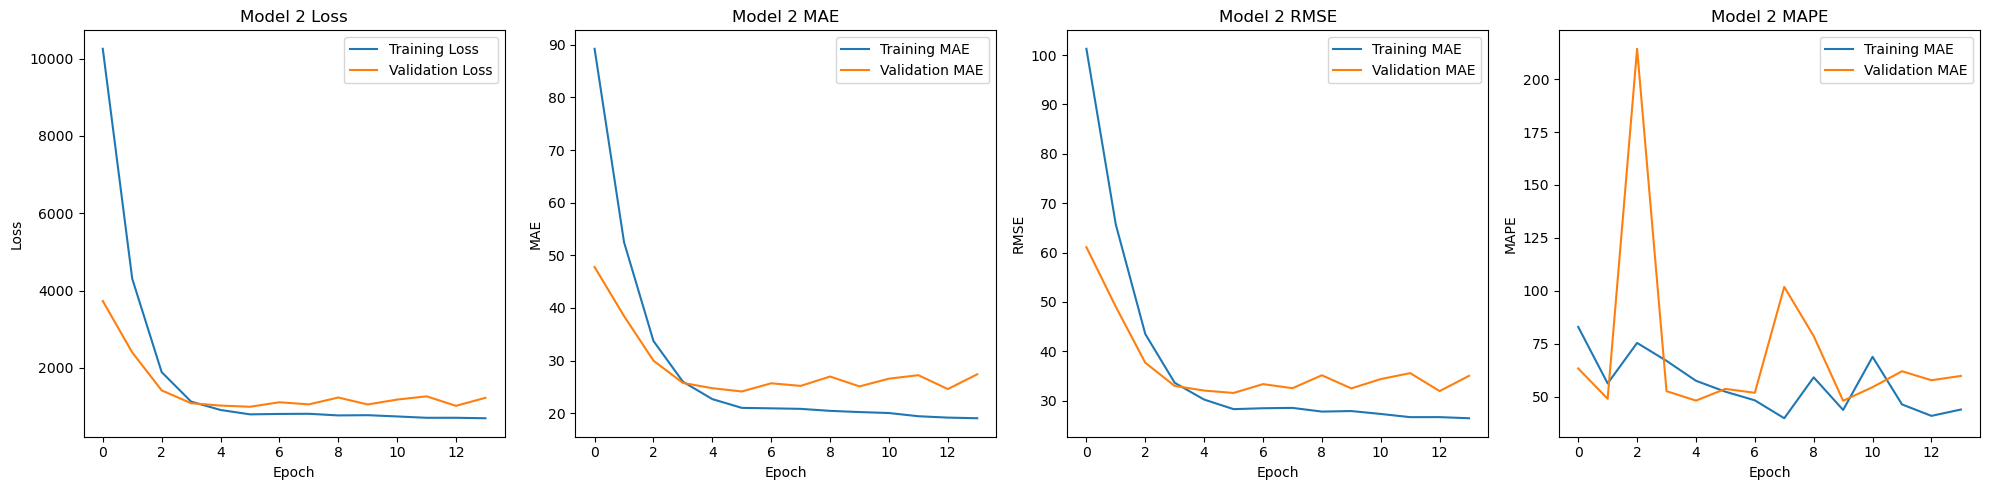

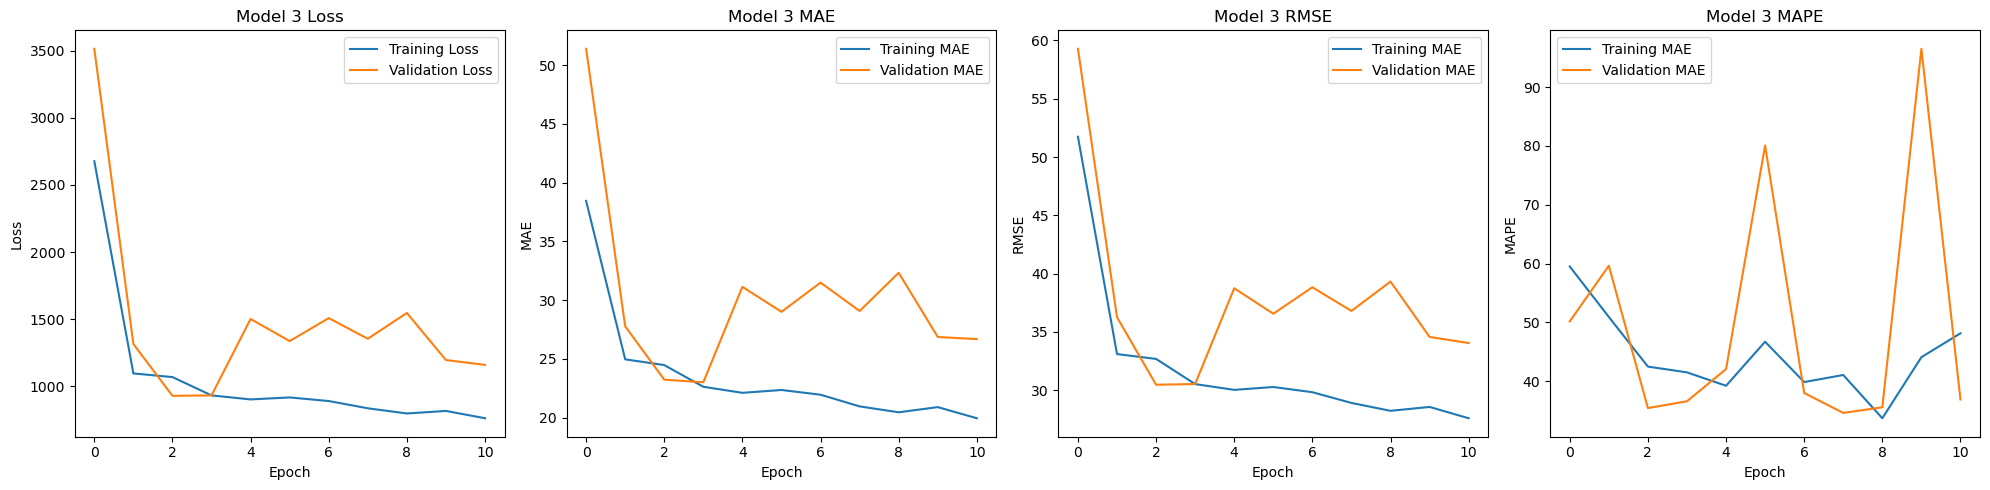

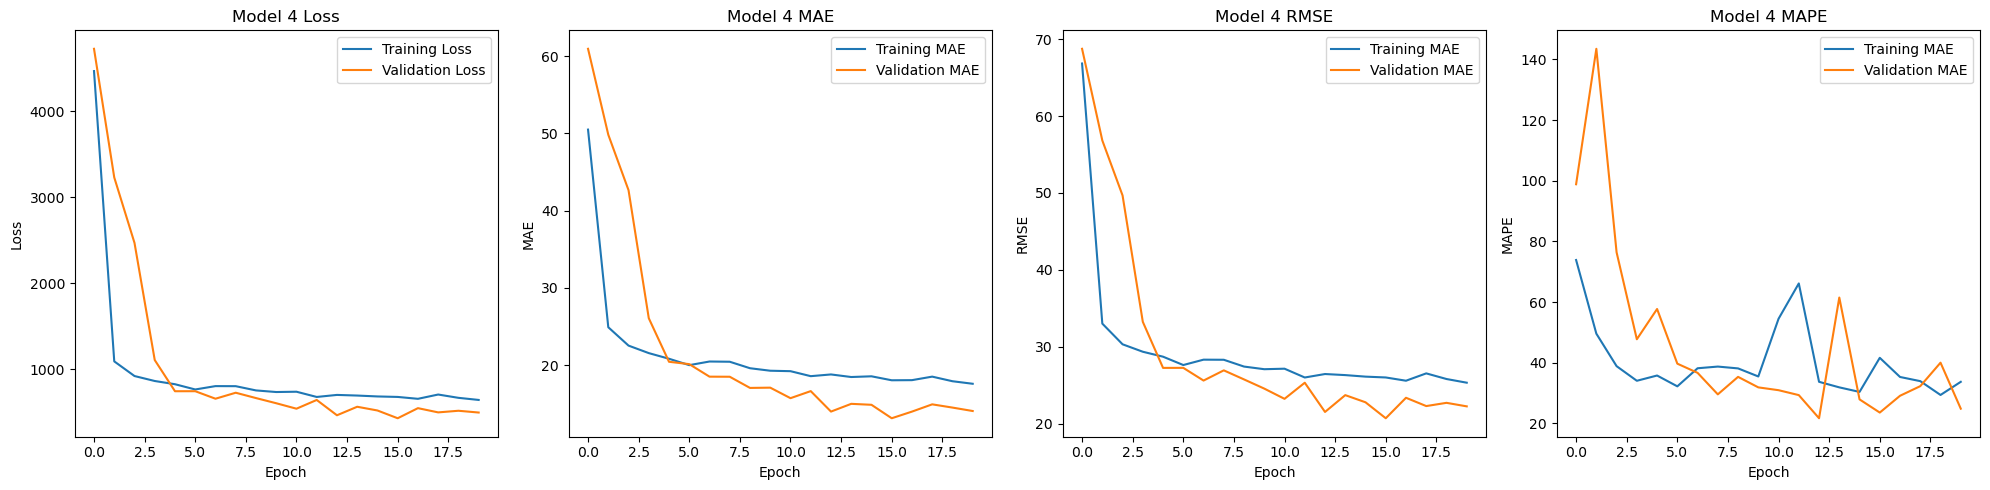

In [37]:
for i in range(4):
    with open(f'model_history{i+1}.pickle', "rb") as pickle_file:
        history = pickle.load(pickle_file)
    plot_metrics(history, i+1)


We can see that the graphs presented are not perfect, as a lot of fluctuations appear. That is to be expected as data is continuously generated and can very a lot from previous iterations on each epoch. We can clearly see that overfitting appears on model number 2 and 3, while model number 1 and 4 are quite ok when it comes to overfiting. What is more model number 4 seems to be the moast stable in terms of all metrics, and usually manages to get error values of validation sets even below the training set, which is really surprising in a good way. The only downside of that model is that the number of epochs was relatively high compared to other models.

The following results inform us, that the forth model is the best out of all the models trained, as not only it achieves the best result on the test set, but is also able to overcome overfitting, as well as produce relatively good results on generated data for all three sets - train, validation and test.

## Filter applied to the best model output in our docker application.

In [ ]:
import json

class Filter:
    def __init__(self, json_descr_path: str):
        with open(json_descr_path, 'r') as f:
            data = json.load(f)
            self.image = cv2.imread(f"filters/{data['file_path']}")
            self.ref_points = data['reference_points']
    def show_image(self):
        plt.imshow(cv2.cvtColor(self.image, cv2.COLOR_BGR2RGB))
    def warp_to_points(self, points: dict) -> np.array:
        dst = []
        src = []
        for keypoint_name in self.ref_points:
            if keypoint_name in points:
                dst.append(points[keypoint_name])
                src.append(self.ref_points[keypoint_name])
        assert len(dst) == len(src) == 4
        src = np.array(src, dtype=np.float32)
        dst = np.array(dst, dtype=np.float32)
        matrix = cv2.getPerspectiveTransform(src, dst)
        return cv2.warpPerspective(self.image, matrix, (INPUT_SIZE[0], INPUT_SIZE[1]), cv2.INTER_LINEAR, borderMode=cv2.BORDER_CONSTANT)

glasses = Filter('filters/sunglasses.json')
glasses_warped = cv2.cvtColor(glasses.warp_to_points(keyps), cv2.COLOR_BGR2GRAY)
plt.imshow(glasses_warped, cmap='gray')

In [ ]:
def combine_image_and_filter(img: np.array, filter: np.array) -> np.array:
    pseudo_alpha_filter = (filter > 0).astype(np.uint8)
    inverse_pseudo_alpha_filter = np.ones(INPUT_SIZE[:2]) - pseudo_alpha_filter
    return filter * pseudo_alpha_filter + inverse_pseudo_alpha_filter * img.squeeze()

plt.imshow(combine_image_and_filter(img, glasses_warped), cmap = 'gray')

## Task completion table.

**Problem**

| Requirements                                    | Description and Link                         | Points  |
|-------------------------------------------------|----------------------------------------------|---------|
| Pose Estimation                                 | [Problem](#problem)                                     |    4    |
| Additional Problem for Accuracy Improvement     | In application                               |    1    |

**Model**

| Requirements                                    | Description and Link                         | Points  |
|-------------------------------------------------|----------------------------------------------|---------|
| 1st Model - Own Architecture                    | [Model 1](#model-1)                                      |    2    |
| Subsequent Model - Different Architecture       | [Model 2](#model-2)                                      |    1    |
| Subsequent Model - Own Architecture             | [Model 3](#model-3)                                       |    2    |
| Subsequent Model - Different Architecture       | [Model 4](#model-4)                                      |    1    |

**Dataset**

| Requirements                                    | Description and Link                         | Points  |
|-------------------------------------------------|----------------------------------------------|---------|
| Evaluation on a set with at least 10,000 images | [Generating test set](#test-gen)                          |    1    |

**Training**

| Requirements                                    | Description and Link                         | Points  |
|-------------------------------------------------|----------------------------------------------|---------|
| Data Augmentation                               | [Data Generation](#data-gen)                              |    1    |

**Tools**

| Requirements                                    | Description and Link                         | Points  |
|-------------------------------------------------|----------------------------------------------|---------|
| Run as Docker                                   | In application                               |    1    |
| REST API or GUI for example Gradio              | In application                               |    1    |

**Total number of points:** 15


## Bibliography.